<a href="https://colab.research.google.com/github/OH1107/edu/blob/master/fintech/200916_StockAnalysis_BQ%EC%97%B0%EB%8F%99_CJENM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.패키지 설치

In [ ]:
%config InlineBackend.figure_format = 'retina'
!apt -qq -y install fonts-nanum

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()
mpl.pyplot.rc('font', family='NanumGothic')
fm._rebuild()

mpl.rcParams['axes.unicode_minus'] = False

In [ ]:
import requests
from bs4 import BeautifulSoup as bs

In [ ]:
! pip install mpl_finance

# 2.주식 크롤링
- CJ ENM: 035760

In [ ]:
def one_page_crawling(code,page):
  url='https://finance.naver.com/item/sise_day.nhn?code={code}&page={page}'.format(code=code,page=page)
  df = pd.read_html(url)[0]
  df.dropna(inplace=True)
  df['날짜'] = df['날짜'].apply(lambda x : str(x).replace('.',''))
  df['날짜'] = df['날짜'].astype('int')
  df.columns = ['SDAY','CLOSEP','SCOMP','OPENP','HIGHP','LOWP','VOL']
  return df

In [ ]:
def several_page_crawling(code,page):
  url='https://finance.naver.com/item/sise_day.nhn?code={code}&page={page}'.format(code=code,page=page)
  df = pd.DataFrame()
  for i in range(1,page+1):
    new_df = one_page_crawling(code,i)
    df = pd.concat([df,new_df], axis=0)
  df.dropna(inplace=True)
  df.reset_index(inplace=True, drop=True)
  return df

In [ ]:
cjenm = several_page_crawling('035760',511)
cjenm

,SDAY,CLOSEP,SCOMP,OPENP,HIGHP,LOWP,VOL
0,20200916,145300.0,9800.0,135700.0,148100.0,135600.0,507364.0
1,20200915,135500.0,1200.0,135400.0,136000.0,130900.0,169950.0
2,20200914,134300.0,4100.0,131300.0,135600.0,130600.0,207924.0
3,20200911,130200.0,200.0,129500.0,130800.0,127100.0,106392.0
4,20200910,130000.0,4300.0,128900.0,131000.0,126800.0,142481.0
...,...,...,...,...,...,...,...
5102,19991129,50900.0,5400.0,50900.0,50900.0,48100.0,1048545.0
5103,19991126,45500.0,4850.0,45500.0,45500.0,45500.0,191164.0
5104,19991125,40650.0,4350.0,40650.0,40650.0,40650.0,22782.0
5105,19991124,36300.0,3850.0,36300.0,36300.0,36300.0,6500.0


In [ ]:
#bigquery 연동
from pandas.io import gbq
cjenm.to_gbq(destination_table='NaverStock.CJENM', 
                  project_id='decisive-clover-286903',    # 내 빅쿼리 ID 넣을 것
                  if_exists='replace')

1it [00:05,  5.16s/it]


- 하강탄력 상승탄력?
- 영화산업이 주가에 영향을 많이 주었는가?
- 그렇다면, '기생충'의 검색어의 영향은?

# 3.주가 분석

## (1) 전체 주가 시각화

In [ ]:
from pandas.io import gbq

project_id = 'decisive-clover-286903'
sql = """
    SELECT SDAY,OPENP,CLOSEP,HIGHP,LOWP,VOL
    FROM `NaverStock.CJENM`
    ORDER BY SDAY desc

    """
cjenm = pd.read_gbq(sql, project_id=project_id, dialect='standard')

In [ ]:
cjenm_df

,SDAY,OPENP,CLOSEP,HIGHP,LOWP,VOL
0,20200916,135700.0,145300.0,148100.0,135600.0,507364.0
1,20200915,135400.0,135500.0,136000.0,130900.0,169950.0
2,20200914,131300.0,134300.0,135600.0,130600.0,207924.0
3,20200911,129500.0,130200.0,130800.0,127100.0,106392.0
4,20200910,128900.0,130000.0,131000.0,126800.0,142481.0
...,...,...,...,...,...,...
5102,19991129,50900.0,50900.0,50900.0,48100.0,1048545.0
5103,19991126,45500.0,45500.0,45500.0,45500.0,191164.0
5104,19991125,40650.0,40650.0,40650.0,40650.0,22782.0
5105,19991124,36300.0,36300.0,36300.0,36300.0,6500.0


In [ ]:
#고가
print(cjenm_df[cjenm_df['CLOSEP']==cjenm_df['CLOSEP'].max()])
print('\n\n')
#저가
print(cjenm_df[cjenm_df['CLOSEP']==cjenm_df['CLOSEP'].min()])

          SDAY     OPENP    CLOSEP     HIGHP      LOWP      VOL
1649  20140102  418900.0  426100.0  426500.0  415400.0  21871.0



          SDAY    OPENP   CLOSEP    HIGHP     LOWP       VOL
4875  20001220  13550.0  13050.0  14000.0  12850.0  141713.0


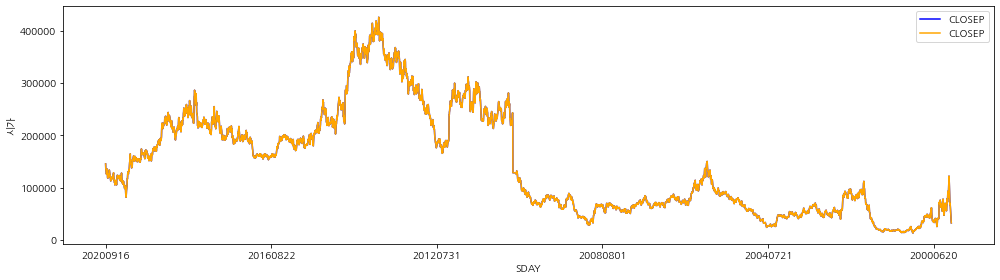

In [ ]:
cjenm_df['SDAY']=cjenm_df['SDAY'].astype('str')
plt.rcParams["figure.figsize"] = (14,4)
ax=cjenm_df.plot(kind='line', x='SDAY', y='CLOSEP', color='Blue')
ax2=cjenm_df.plot(kind='line', x='SDAY', y='CLOSEP', color='orange', ax=ax)
ax.set_ylabel('종가')
ax2.set_ylabel('시가')

plt.tight_layout()
plt.show()

- 2010년 9월 급등이 보인다.
- 2011년 3월에는 CJ엔터테인먼트·CJ미디어·온미디어·엠넷미디어·CJ인터넷·오미디어홀딩스 등 6개 콘텐츠 관련 계열사를 CJ E&M으로 인수 합병했다.
- 2012년 3~4월에서는 급감이 보인다. 
- 2012년 8월부터 2014년 1월에도 급등이 보인다. 이 사이에 개봉한 영화는 《광해, 왕이 된 남자》,《늑대소년》,《가디언즈》,《베를린》,《설국열차》등이 있다.

## (2) 이동평균선
- 주가 기술분석
- 단기이평선(5일 이평선), 장기이평선(30일 이평선)을 설정하여 장단기이평선을 분석
- 골든크로스(단기이평선이 장기이평선을 아래서 위로 통과)
- 데드크로스(단기이평선이 장기이평선을 위에서 아래로 통과)
- 마케팅의 시장평가 지점을 지정

In [ ]:
project_id = 'decisive-clover-286903'
sql = """
    SELECT SDAY,OPENP,CLOSEP,HIGHP,LOWP,VOL
    FROM `NaverStock.CJENM`
    WHERE SDAY > 20200101
    ORDER BY SDAY desc
    LIMIT 250

    """
cjenm_df = pd.read_gbq(sql, project_id=project_id, dialect='standard')
cjenm_df.head()

,SDAY,OPENP,CLOSEP,HIGHP,LOWP,VOL
0,20200916,135700.0,145300.0,148100.0,135600.0,507364.0
1,20200915,135400.0,135500.0,136000.0,130900.0,169950.0
2,20200914,131300.0,134300.0,135600.0,130600.0,207924.0
3,20200911,129500.0,130200.0,130800.0,127100.0,106392.0
4,20200910,128900.0,130000.0,131000.0,126800.0,142481.0


In [ ]:
#이평선 함수 만들기
import numpy as np

def makeMV(baseday=5,basedata=cjenm_df['CLOSEP']):
  res = []
  #초기화 하기
  for i in range(baseday-1):
    res.append(0)
  #이동평균데이터 만들기
  n = len(basedata) - (baseday - 1)
  print('총 데이터수:', len(basedata),"초기화 안되고 채워야할 부분:",n)
  for i in range(n):
    mvdata = np.average(basedata[i:i+baseday])
    res.append(mvdata)
  return res

In [ ]:
cjenm_df['MV5']=makeMV(5)
cjenm_df['MV30']=makeMV(30)
cjenm_df.head()

총 데이터수: 178 초기화 안되고 채워야할 부분: 174
총 데이터수: 178 초기화 안되고 채워야할 부분: 149


,SDAY,OPENP,CLOSEP,HIGHP,LOWP,VOL,MV5,MV30
0,20200916,135700.0,145300.0,148100.0,135600.0,507364.0,0.0,0.0
1,20200915,135400.0,135500.0,136000.0,130900.0,169950.0,0.0,0.0
2,20200914,131300.0,134300.0,135600.0,130600.0,207924.0,0.0,0.0
3,20200911,129500.0,130200.0,130800.0,127100.0,106392.0,0.0,0.0
4,20200910,128900.0,130000.0,131000.0,126800.0,142481.0,135060.0,0.0


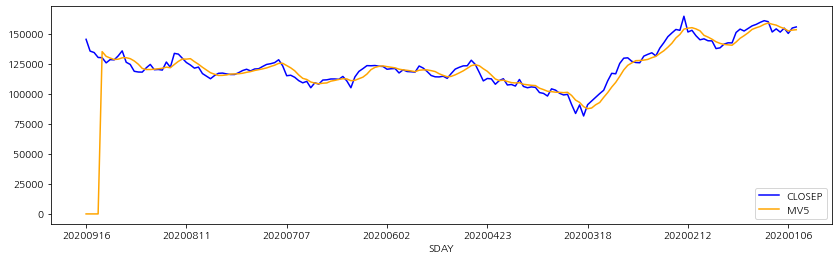

In [ ]:
cjenm_df['SDAY']=cjenm_df['SDAY'].astype('str')
ax=cjenm_df.plot(kind='line', x='SDAY', y='CLOSEP', color='Blue')
ax2=cjenm_df.plot(kind='line', x='SDAY', y='MV5', color='orange', ax=ax)
plt.legend()
plt.show()

- 주가 이동의 평균치를 5일로 잡았기 때문에 효과는 5일뒤에 나타남을 알 수 있다

## (3) 장단기 크로스포인트 분석
- 주가 장단기 이평선에 관한 크로스포인트 분석
- 이를 통해 시장에 반영된 마케팅 기준선을 부여
- 골든크로스(단기이평선이 장기이평선을 아래서 위로 통과)
- 데드크로스(단기이평선이 장기이평선을 위에서 아래로 통과)

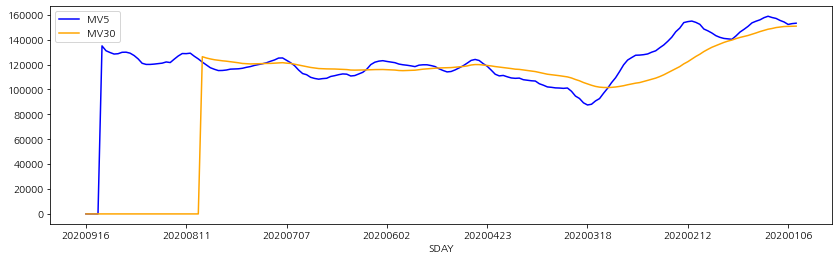

In [ ]:
plt.rcParams["figure.figsize"] = (14,4)
ax=cjenm_df.plot(kind='line', x='SDAY', y='MV5', color='Blue')
ax2=cjenm_df.plot(kind='line', x='SDAY', y='MV30', color='orange', ax=ax)
plt.legend()
plt.show()

In [ ]:
short=cjenm_df['MV5']
long=cjenm_df['MV30']
res=[]
longday=30
for i in range(longday):
    res.append(0)
    
for i in range(longday,len(short)):
    if(short[i]>long[i]):
        res.append(1)        # 보유 or 매수 해라
    else:
        res.append(-1)       # 매도 해라
cjenm_df['holdPos']=res
cjenm_df.head()

,SDAY,OPENP,CLOSEP,HIGHP,LOWP,VOL,MV5,MV30,holdPos
0,20200916,135700.0,145300.0,148100.0,135600.0,507364.0,0.0,0.0,0
1,20200915,135400.0,135500.0,136000.0,130900.0,169950.0,0.0,0.0,0
2,20200914,131300.0,134300.0,135600.0,130600.0,207924.0,0.0,0.0,0
3,20200911,129500.0,130200.0,130800.0,127100.0,106392.0,0.0,0.0,0
4,20200910,128900.0,130000.0,131000.0,126800.0,142481.0,135060.0,0.0,0


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


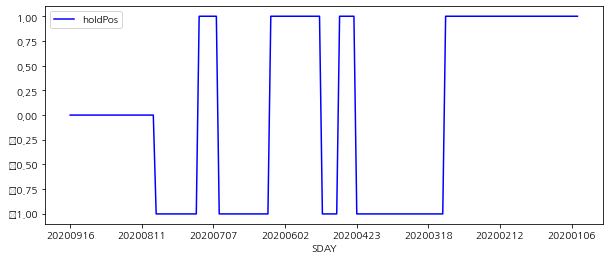

In [ ]:
plt.rcParams["figure.figsize"] = (10,4)
ax=cjenm_df.plot(kind='line', x='SDAY', y='holdPos', color='Blue')
plt.legend()
plt.show()

## (4) 성장동력과 크로스포인트와의 관계
- 장단기크로스지점
- 단기 성장성(성장비율)과 장단기 주가 모멘텀 분석
- 실질적 주가에 영향을 주는 마케팅 포인트 지점 획득
- 단기물(5일물)<장기물(60일물):매도
- 단기물(5일물)>장기물(60일물):매수

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


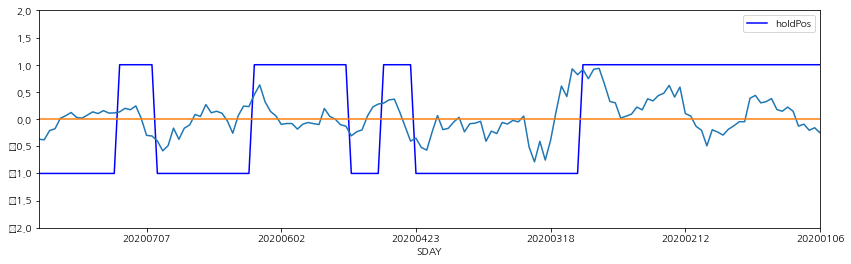

In [ ]:
baseData= cjenm_df['MV5']
res=[1]
for i in range(1,len(baseData)):
    c=((baseData[i]/baseData[i-1]) - 1)*20  # 전일대비 단기이평선의 상승비율
    res.append(c)


plt.rcParams["figure.figsize"] = (14,4)
ax=cjenm_df.plot(kind='line', x='SDAY', y='holdPos', color='Blue')
plt.plot(res)
plt.plot([0,175],[0,0])
plt.xlim(30,175)
plt.ylim(-2,2)
plt.legend()

plt.show()

- 0(노란선)을 기준으로 위쪽은 매수(보유), 아래쪽은 매도

# 4.캔들차트
- 시가, 고가, 저가, 종가를 분석하여 마케팅의 적시적 효과를 보기 위함
- 라이브러리 사용

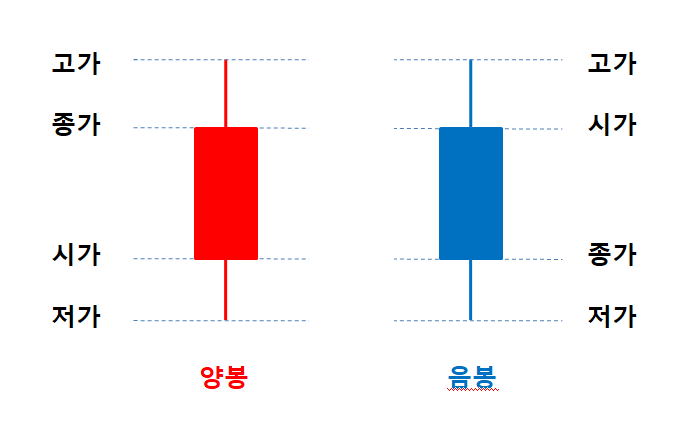



In [ ]:
from mpl_finance import candlestick_ohlc

cols = ['OPENP','HIGHP','LOWP','CLOSEP']
lMin=70
lMax=108

days = cjenm_df['SDAY'].values[lMin:lMax]   # x축에 들어갈 값 = 날짜
cdata = cjenm_df[cols].values[lMin:lMax]    # 첫번째 그래프의 데이터 = OP LP HP CP
voldata=cjenm_df['VOL'].values[lMin:lMax]   # 두번째 그래프의 데이터 = VAL(거래량)
gmv5=cjenm_df['MV5'].values[lMin:lMax]      # 5일 이평선
gmv30=cjenm_df['MV30'].values[lMin:lMax]    # 30일 이평선

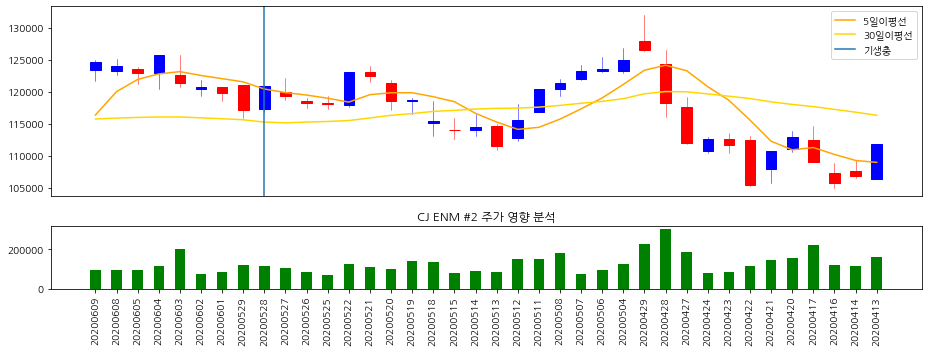

In [ ]:
fig = plt.figure(figsize=(13,5))                  # 그림비율
gs = gridspec.GridSpec(2,1,height_ratios=[3,1])   # 그리드 2행 1열짜리 높이비율 3:1로 생성
axis=[]
axis.append(plt.subplot(gs[0]))                   # 축 선정
axis.append(plt.subplot(gs[1],sharex=axis[0]))    # x축을 서로 공유
axis[0].get_xaxis().set_visible(False)            # 공유x축 표시 없애기


x = np.arange(len(cdata))
xa = np.reshape(x,(-1,1))
ohlc = np.hstack((xa,cdata))

candlestick_ohlc(axis[0],ohlc,width=0.5,colorup='red',colordown='blue')
axis[1].bar(days,voldata,color='g',width=0.5)
axis[0].plot(gmv5,label="5일이평선",color='orange')     # MV5추가
axis[0].plot(gmv30,label="30일이평선",color='gold')     # MV30추가
# axis[0].axvline(x=8,label='기생충')     # 세로선 추가
axis[0].legend()
plt.title('CJ ENM #2 주가 영향 분석')             # 2번 이벤트가 주가에 준 영향
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

- 2020년 4/24 ~ 4/28 주가와 거래량이 급등한 걸 확인할 수 있다.
- 4/24 CJ ENM - JTBC OTT 합작 법인 설립 계약을 체결한 것이 영향을 주지 않았나 추측가능하다.
  + OTT:온라인동영상서비스

# 5.경쟁사 주식 알아보기
- GS홈쇼핑: 028150

## (1) 주식크롤링

In [ ]:
gshome=several_page_crawling('028150',507)
gshome

,SDAY,CLOSEP,SCOMP,OPENP,HIGHP,LOWP,VOL
0,20200916,134200.0,5300.0,129000.0,135400.0,128400.0,67177.0
1,20200915,128900.0,500.0,128500.0,130900.0,127800.0,39410.0
2,20200914,128400.0,1500.0,130500.0,133300.0,127800.0,69755.0
3,20200911,129900.0,7900.0,122100.0,130400.0,121000.0,118493.0
4,20200910,122000.0,1400.0,121300.0,123100.0,119300.0,46240.0
...,...,...,...,...,...,...,...
5065,20000127,85100.0,11500.0,87300.0,97600.0,85100.0,552586.0
5066,20000126,96600.0,10300.0,96600.0,96600.0,91000.0,855067.0
5067,20000125,86300.0,9200.0,86300.0,86300.0,86300.0,10794.0
5068,20000124,77100.0,8200.0,77100.0,77100.0,77100.0,503.0


In [ ]:
gshome_eng.to_gbq(destination_table='NaverStock.GSHS', 
                  project_id='decisive-clover-286903',    # 내 빅쿼리 ID 넣을 것
                  if_exists='replace')

1it [00:04,  4.14s/it]


In [ ]:
project_id = 'decisive-clover-286903'
sql = """
    SELECT SDAY,OPENP,CLOSEP,HIGHP,LOWP,VOL
    FROM `NaverStock.GSHS`
    WHERE SDAY > 20200101
    ORDER BY SDAY desc
    LIMIT 250
    """
gshome_df = pd.read_gbq(sql, project_id=project_id, dialect='standard')
gshome_df.head()

,SDAY,OPENP,CLOSEP,HIGHP,LOWP,VOL
0,20200916,129000.0,134900.0,135000.0,128400.0,51226.0
1,20200915,128500.0,128900.0,130900.0,127800.0,39410.0
2,20200914,130500.0,128400.0,133300.0,127800.0,69755.0
3,20200911,122100.0,129900.0,130400.0,121000.0,118493.0
4,20200910,121300.0,122000.0,123100.0,119300.0,46240.0


## (2) CJ-GS비교

In [ ]:
cj_gs=pd.DataFrame([cjenm_df_20200101['SDAY'],cjenm_df['CLOSEP'],gshome_df['CLOSEP']]).T
cj_gs.columns=['SDAY','CJ_CLOSEP','GS_CLOSEP']
cj_gs

,SDAY,CJ_CLOSEP,GS_CLOSEP
0,20200916,145300,134900
1,20200915,135500,128900
2,20200914,134300,128400
3,20200911,130200,129900
4,20200910,130000,122000
...,...,...,...
173,20200108,151300,139400
174,20200107,154600,142000
175,20200106,150200,143000
176,20200103,154700,145800


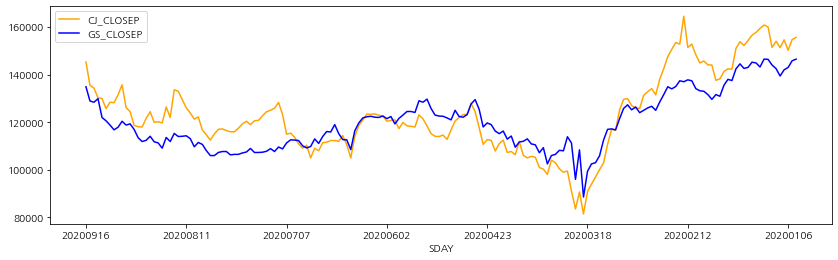

In [ ]:
plt.rcParams["figure.figsize"] = (14,4)
ax=cj_gs.plot(kind='line', x='SDAY', y='CJ_CLOSEP', color='Orange')
ax2=cj_gs.plot(kind='line', x='SDAY', y='GS_CLOSEP', color='Blue', ax=ax)
plt.legend()
plt.show()

- GS랑, CJ 주가를 비교해보았다.
- 2020년 2월 이전에는 CJ가 GS보다 우세했다.
- 2020년 3월부터 2020년 7월초반까지 GS가 CJ보다 우세했다.
- 2020년 7월 이후 다시 CJ가 우위에 있다.
- 중간에 GS가 CJ보다 우세했던 이유는 무엇일까?
- 이에 관련하여 해당시기의 마케팅전략,합병 등을 분석해볼 필요가 있다.